# Model uses GMM to initialize the values for Poisson Mixture Model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
from scipy.optimize import curve_fit
import math

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Sat Apr 18 2020 

numpy 1.18.1
scipy 1.4.1
pomegranate 0.11.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Possion Data


In [2]:
df =  pd.read_csv(r'D:\Studies\Corona Research\Country-wise_data_testing_information\data.csv', encoding = 'utf8')
df.head(5)

,dateRep,cum_day,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,Daily total tests,Daily change in cumulative total tests per thousand,Total tests per thousand
0,31-12-2019,1,31,12,2019,0,0,Belgium,BE,BEL,11422068,0.0,0.0,0.0
1,01-01-2020,2,1,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.0,0.0
2,02-01-2020,3,2,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.0,0.0
3,03-01-2020,4,3,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.0,0.0
4,04-01-2020,5,4,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.0,0.0


In [3]:
country_list = list(df['countriesAndTerritories'].unique())

In [103]:
def generator(n_mixtures, country_list,dataframe):
#     X = np.reshape(np.array(df[df['countriesAndTerritories']== 'country_list[_]'].cases),(-1,1))


    iterations = len(country_list)
#     iterations = 1
    data_list = []
    components = []
    cum_stages = []
    dicti = dict()
    for j in range(iterations):
        input_data =  np.reshape(np.array(df[df['countriesAndTerritories']== country_list[j]].cases),(-1,1))
#         dates = np.reshape(np.array(df[df['countriesAndTerritories']== country_list[j]].dateRep),(-1,1))
        input_data_gmm = pd.DataFrame([df[df['countriesAndTerritories']== country_list[j]].cum_day,
                                   df[df['countriesAndTerritories']== country_list[j]].cases]).T
        dates = list(df[df['countriesAndTerritories']== country_list[j]].dateRep)
        cum_days = list(df[df['countriesAndTerritories']== country_list[j]].cum_day)
        
        gmm = mixture.GaussianMixture(n_components=n_mixtures,covariance_type='diag')
        gmm.fit(input_data_gmm)
        means=gmm.means_
        d1 = PoissonDistribution(means[0][1])
        d2 = PoissonDistribution(means[1][1])
        d3 = PoissonDistribution(means[2][1])
        d4 = PoissonDistribution(means[3][1])
        model = GeneralMixtureModel([d1,d2,d3,d4])
        model.fit(input_data)
#         model = GeneralMixtureModel.from_samples(distribution, n_components=n_mixtures, X=input_data)
        sequence = model.predict(input_data)
        unique_elements, counts_elements = np.unique(sequence, return_counts=True)
        model.clear_summaries()
        para = []
        for i in range(n_mixtures):
            para.append(model.distributions[i].parameters)

#for getting the stages based on the components             
        
        rank = rankdata(para, method='ordinal')
        stages = []
        for _ in range(len(sequence)):
            if sequence[_]==0:
                stages.append(rank[0])
                continue
            elif sequence[_]==1:
                stages.append(rank[1])
                continue
            elif sequence[_]==2:
                stages.append(rank[2])
                continue
            else:
                stages.append(rank[3])
        
        data_list = [np.short(para,axis=0),list(zip(unique_elements,counts_elements)),list(zip(cum_days,list(stages)))]
        dicti[country_list[j]] =data_list
        components.extend(sequence)
        cum_stages.extend(stages)
    return dicti,cum_stages,components


In [92]:
results, cumulative_stages,components = generator(4,country_list,df)  

df['Stages']=cumulative_stages
df['Components']=components

In [65]:
country_list

['Belgium',
 'France',
 'India',
 'Italy',
 'South_Korea',
 'United_Kingdom',
 'United_States_of_America']

In [9]:
country_list

['Belgium',
 'France',
 'India',
 'Italy',
 'South_Korea',
 'United_Kingdom',
 'United_States_of_America']

In [104]:
def plot_results(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df[df['countriesAndTerritories']==country].cum_day,df[df['countriesAndTerritories']==country].cases,
            c=df[df['countriesAndTerritories']==country].Stages)
    plt.title('Scatter plot of Components') #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    plt.colorbar()
    plt.show()

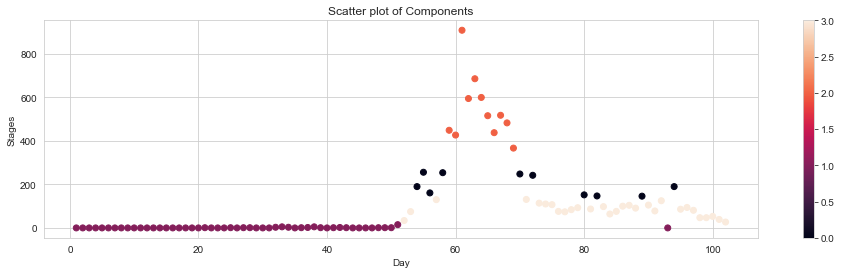

In [100]:
plot_results('South_Korea')

In [71]:
def clustervsstages(country):
    plt.figure(figsize=(16,4))
    plt.scatter(df[df['countriesAndTerritories']==country].cum_day,df[df['countriesAndTerritories']==country].Stages,
            c=df[df['countriesAndTerritories']==country].Stages)
    plt.title('Scatter plot of Components') #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    plt.colorbar()
    plt.show()

### Just need to give the name of the country as input and it will display the corresponding results. The result consists of the array of parameters, pair of the component and its count, the array of the predicted values.

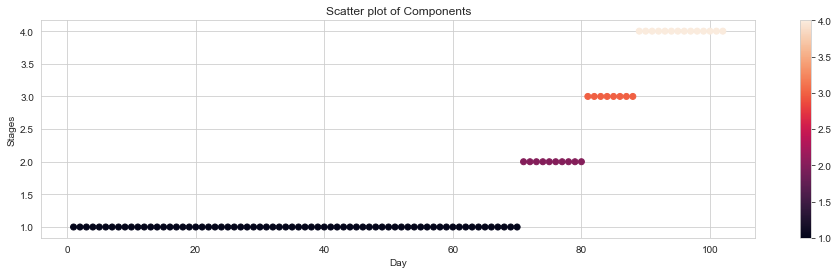

In [85]:
clustervsstages('United_States_of_America')

# Miscellaneous

In [14]:
# z =np.polyfit(df[df['countriesAndTerritories']=='South_Korea'].cum_day,
#               df[df['countriesAndTerritories']=='South_Korea'].Stages,deg=2)

In [15]:
# p = np.poly1d(z)
# xp = np.linspace(1, 500, 500)
# _ = plt.plot(df[df['countriesAndTerritories']=='South_Korea'].cum_day,
#              df[df['countriesAndTerritories']=='South_Korea'].cases, '.', xp,p(xp),'-')
# plt.ylim(-2,10)
# plt.plot()

In [16]:
# p(xp)

In [17]:
# def func(x):
#     return (1/math.pi)*np.exp(x**2)


In [18]:
# from datetime import datetime

# datetime_str = '09/19/18 13:55:26'

# datetime_object = datetime.strptime(a, '%d-%m-%Y')

In [19]:
# a = np.array(df_new.groupby('cum_day')['cases'].max())
# a = np.array(df_new.cum_day)
# b = np.array(df_new.cases)
# co = np.array(df_new.Stages)
# b = np.linspace(1,102,260)
# a = df.groupby('cum_day')['cases'].
# a.size

In [20]:
# plt.figure(figsize=(16,4))
# # plt.scatter(df.cum_day,df.cases,c=df.Stages)
# plt.scatter(a,b, c= co)
# plt.title('Scatter plot of Components') #to undestand the number of components which can be used
# plt.xlabel('Day')
# plt.ylabel('Stages')
# # plt.colorbar()
# plt.show()

In [21]:
idx=df.groupby('cum_day')['cases'].transform(max) == df['cases']
df_new = df[idx]
df_new

,dateRep,cum_day,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,Daily total tests,Daily change in cumulative total tests per thousand,Total tests per thousand,Stages,Components
0,31-12-2019,1,31,12,2019,0,0,Belgium,BE,BEL,11422068,0.0,0.000,0.000,2,3
1,01-01-2020,2,1,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.000,0.000,2,3
2,02-01-2020,3,2,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.000,0.000,2,3
3,03-01-2020,4,3,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.000,0.000,2,3
4,04-01-2020,5,4,1,2020,0,0,Belgium,BE,BEL,11422068,0.0,0.000,0.000,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,06-04-2020,98,6,4,2020,25398,1146,United_States_of_America,US,USA,327167434,149248.0,5.808,0.450,4,1
709,07-04-2020,99,7,4,2020,30561,1342,United_States_of_America,US,USA,327167434,148099.0,6.255,0.447,4,1
710,08-04-2020,100,8,4,2020,30613,1906,United_States_of_America,US,USA,327167434,139536.0,6.676,0.421,4,1
711,09-04-2020,101,9,4,2020,33323,1922,United_States_of_America,US,USA,327167434,162789.0,7.167,0.491,4,1


In [22]:
# list(df.groupby('cum_day')['cases'].max())

In [23]:
# df_china = df[df.Country=='CN']
# china_counts = np.reshape(np.array(df_china.Confirmed),(-1,1))

In [24]:
# plt.figure(figsize=(20,10))
# plt.hist(china_counts, bins='auto')
# plt.show()

In [25]:
# df_china.head(5)

In [26]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_china.day,df_china.Confirmed)
# plt.title('Scatter plot of number of confirmed cases') #to undestand the number of components which can be used
# plt.xlabel('Date')
# plt.ylabel('Counts')
# plt.show()

In [27]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_china.day,df_china['Cumulative Confirmed'])
# plt.title('Scatter plot of number of Cumulative confirmed cases') #to undestand the number of components which can be used
# plt.xlabel('Date')
# plt.ylabel('Counts')
# plt.show()

In [28]:
# plt.figure(figsize=(20,10))
# plt.scatter(df.day,df.Confirmed)
# plt.title('Scatter plot of number of confirmed cases for wholw world') #to undestand the number of components which can be used
# plt.xlabel('Date')
# plt.ylabel('Counts')
# plt.show()

In [29]:
# plt.figure(figsize=(20,10))
# plt.scatter(df.day,df['Cumulative Confirmed'])
# plt.title('Scatter plot of number of the whole world Cumulative confirmed cases') #to undestand the number of components which can be used
# plt.xlabel('Date')
# plt.ylabel('Counts')
# plt.show()

In [30]:
# #removing abnormalities
# df_china.drop(df_china[df_china['Confirmed']==15152].index,inplace=True)

Model for China data with further parameter tuning

In [31]:
# model = GeneralMixtureModel.from_samples(PoissonDistribution, n_components=4, X=china_counts)

In [32]:
# model.distributions[2].parameters
# model.distributions

In [33]:
# model.clear_summaries()

In [34]:
# model.summarize(china_counts)

In [35]:
# components = model.predict(china_counts)

In [36]:
# unique_elements, counts_elements = np.unique(components, return_counts=True)
# counts_elements

Model for total dataset for poisson distribution

In [37]:

# #For total dataset
# model1 = GeneralMixtureModel.from_samples(PoissonDistribution, n_components=3, X=np.reshape(np.array(df['Confirmed']),(-1,1)))
# model1.distributions
# model1.clear_summaries()

In [38]:
# components1 = model1.predict(np.reshape(np.array(df['Confirmed']),(-1,1)))

In [39]:
# unique_elements1, counts_elements1 = np.unique(components1, return_counts=True)

In [40]:
# counts_elements1

In [41]:
# model1.clear_summaries()

Model for China considering Normal Distribution

In [42]:
# model2 = GeneralMixtureModel.from_samples(NormalDistribution, n_components=2, X=china_counts)
# model2.distributions

In [43]:
# components2 = model2.predict(china_counts)
# unique_elements2, counts_elements2 = np.unique(components2, return_counts=True)
# counts_elements2

In [44]:
# model2.clear_summaries()

In [45]:
# Model for whole dataset considering Normal Distribution

# ip = np.reshape(np.array(df[df['countriesAndTerritories']== 'United_States_of_America'].cases),(-1,1))
# d1 = PoissonDistribution(a[0])
# d2 = PoissonDistribution(a[1])
# d3 = PoissonDistribution(a[2])
# d4 = PoissonDistribution(a[3])
# model = GeneralMixtureModel([d1,d2,d3,d4])

In [46]:
# country_list[0]

In [47]:
# model.fit(ip)
# model.distributions
# model.predict(ip)

In [48]:
# ip = np.reshape(np.array(df[df['Country Name']== 'United States of America'].Confirmed),(-1,1))

In [49]:
# X = np.reshape(np.array(df[df['countriesAndTerritories']== 'United_States_of_America'].cases),(-1,1))
# gmm = mixture.GaussianMixture(n_components=4,covariance_type='diag')
# gmm.fit(X)
# a=gmm.means_

In [50]:
# np.array(df[df['countriesAndTerritories']==b[0]].cases)